In [1]:
_TRAIN_SAMPLE_CNT,PIC_H,PIC_W=None,None,None
_TEST_SAMPLE_CNT=None
PIC_HW=None

LINEAR_1_OUT_SIZE=64
R_LINEAR_1_OUT_SIZE=LINEAR_1_OUT_SIZE
CLASS_CNT=10


func: load mnist using keras

In [2]:

import numpy
import numpy as np
def loadMnist() -> (numpy.ndarray,numpy.ndarray,numpy.ndarray,numpy.ndarray):
    """

    :return:  (xTrain,yTrain,xTest,yTest)
    """
    global _TRAIN_SAMPLE_CNT
    global PIC_H
    global PIC_W
    global _TEST_SAMPLE_CNT
    global PIC_HW

    from tensorflow import keras #修改点: tensorflow:2.6.2,keras:2.6.0 此版本下,  import keras 换成 from tensorflow import keras
    import tensorflow
    print(keras.__version__)#2.6.0
    print(tensorflow.__version__)#2.6.2

    # avatar_img_path = "/kaggle/working/data"


    import os

    import cv2

    # img_dataset=load_data()
    # img_dataset.shape
    xTrain:numpy.ndarray; label_train:numpy.ndarray; xTest:numpy.ndarray; label_test:numpy.ndarray
    yTrain:numpy.ndarray; yTest:numpy.ndarray

    #%userprofile%\.keras\datasets\mnist.npz
    (xTrain, label_train), (xTest, label_test) = keras.datasets.mnist.load_data()

    # x_train.shape,y_train.shape, x_test.shape, label_test.shape
    # (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)
    _TRAIN_SAMPLE_CNT,PIC_H,PIC_W=xTrain.shape
    PIC_HW=PIC_H*PIC_W
    xTrain=xTrain.reshape((-1, PIC_H * PIC_W))
    xTest=xTest.reshape((-1, PIC_H * PIC_W))

    _TEST_SAMPLE_CNT=label_test.shape[0]


    from sklearn import preprocessing


    #pytorch 的 y 不需要 oneHot
    #_label_train是1列多行的样子.  _label_train.shape : (60000, 1)
    yTrain=label_train
    # y_train.shape:(60000) ; y_train.dtype: dtype('int')

    CLASS_CNT=yTrain.shape[0]

    yTest=label_test
    # y_test.shape:(10000) ; y_test.dtype: dtype('int')

    xTrainMinMaxScaler:preprocessing.MinMaxScaler; xTestMinMaxScaler:preprocessing.MinMaxScaler
    xTrainMinMaxScaler=preprocessing.MinMaxScaler()
    xTestMinMaxScaler=preprocessing.MinMaxScaler()

    # x_train.dtype: dtype('uint8') -> dtype('float64')
    xTrain=xTrainMinMaxScaler.fit_transform(xTrain)

    # x_test.dtype: dtype('uint8') -> dtype('float64')
    xTest = xTestMinMaxScaler.fit_transform(xTest)

    return (xTrain,yTrain,xTest,yTest)
##}


import

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


ArgDto

In [4]:
class Args:
    def __init__(self):
        self.epochs = 40
        self.lr = 1.0
        self.gamma = 0.7
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 100
        self.save_model = True

    def update(self, d):
        self.__dict__.update(d.__dict__)


class TrainArgs(Args):
    def __init__(self):
        Args.__init__(self)
        self.batch_size = 50


class TestArgs(Args):
    def __init__(self):
        Args.__init__(self)
        self.batch_size = 1000


class CudaArgs():
    def __init__(self):
        # cuda_kwargs:
        self.num_workers = 1
        self.pin_memory = True
        self.shuffle = True

    def update(self, d):
        self.__dict__.update(d.__dict__)


prepare

In [5]:
args = Args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

trainArgs = TrainArgs()
test_kwargs = TestArgs()
if use_cuda:
    cuda_kwargs = CudaArgs()
    trainArgs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


loadMnist

In [6]:
(xTrain,yTrain,xTest,yTest)=loadMnist()

xTrain=torch.Tensor(xTrain).type(torch.float32)
yTrain=torch.Tensor(yTrain).type(torch.int64)
xTest=torch.Tensor(xTest).type(torch.float32)
yTest=torch.Tensor(yTest).type(torch.int64)


2.6.0
2.6.2
11501568/11490434 [==============================] - 0s 0us/step


Net, RNet

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(PIC_H * PIC_W, LINEAR_1_OUT_SIZE)
        self.linear2 = nn.Linear(LINEAR_1_OUT_SIZE, CLASS_CNT)

    def forward(self, xflat):
        # print(f"xflat:{xflat.dtype}, {xflat.shape}") #torch.float32, torch.Size([50, 784])
        linear1_out = self.linear1(xflat)
        linear1_out_active = F.relu(linear1_out)
        linear2_out = self.linear2(linear1_out_active)
        linear2_out_active = F.log_softmax(linear2_out, dim=1)
        # print(f"linear2_out_active:{linear2_out_active.shape}")
        # linear2_out_active:torch.Size([50, 10])
        return linear2_out_active,linear1_out_active #重点:返回每一层的激活值


class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.rlinear1 = nn.Linear(CLASS_CNT, R_LINEAR_1_OUT_SIZE)
        self.rlinear2 = nn.Linear(R_LINEAR_1_OUT_SIZE, PIC_H * PIC_W)

    def forward(self, linear2_out_active):
        # print(f"xflat:{xflat.dtype}, {xflat.shape}") #torch.float32, torch.Size([50, 784])
        rlinear1_out = self.rlinear1(linear2_out_active)
        rlinear1_out_active = F.relu(rlinear1_out)
        rlinear2_out = self.rlinear2(rlinear1_out_active)
        return rlinear2_out



func:train,test

In [8]:
def train(trainArgs:TrainArgs, model:Net, rmodel:RNet, device, xTrain:torch.Tensor,yTrain:torch.Tensor, optimizer,roptimizer, epoch):
    model.train()#模型设置为训练模式
    rmodel.train()#模型设置为训练模式
    batch_size=trainArgs.batch_size
    batch_cnt = int(_TRAIN_SAMPLE_CNT / batch_size)

    for batch_index in range(batch_cnt):
        beginIndex=batch_index * batch_size
        endIndex=(batch_index + 1) * batch_size
        x=xTrain[beginIndex: endIndex]
        y=yTrain[beginIndex:endIndex]
        x, y = x.to(device), y.to(device)
#         print(f"zzz:{data.shape},{target.shape}")

        optimizer.zero_grad() # 用 optimizer.zero_grad() 还是 model.zero_grad(), 试了一下 感觉一样的. 但不知道两者差异
        # model.zero_grad()
        linear2_out_active,linear1_out_active = model(x)#linear2_out_active,linear1_out_active #重点:必须拿到每一层的激活值
        # linear2_out_active=output: ŷ
        # print(f"output:{output.shape} ,{output.dtype} ; y:{y.shape},{y.dtype}")
        # output:torch.Size([50, 10]) ,torch.float32 ; y:torch.Size([50]),torch.int64
        loss = F.nll_loss(linear2_out_active, y)
        loss.backward()
        optimizer.step()

        roptimizer.zero_grad() # 用 roptimizer.zero_grad() 还是 rmodel.zero_grad(), 试了一下 感觉一样的. 但不知道两者差异
        # rmodel.zero_grad()
        linear2_out_active_detach=torch.Tensor(linear2_out_active.detach())#重点:detach
        rlinear2_out  = rmodel(linear2_out_active_detach)
        # print(f"output:{output.shape} ,{output.dtype} ; y:{y.shape},{y.dtype}")
        # output:torch.Size([50, 10]) ,torch.float32 ; y:torch.Size([50]),torch.int64
        x_detach=torch.Tensor(x.detach()) #重点:detach
        rloss = F.mse_loss(rlinear2_out, x_detach) #重点:mse_loss
        # print(f"rloss:{type(rloss.item())}")#rloss:<class 'float'>
        rloss.backward()
        roptimizer.step()

        if batch_index % trainArgs.log_interval == 0:
            sample_idx=batch_index * len(x)
            batch_progress=100. * batch_index / batch_cnt
            print(f'Train Epoch: {epoch} [{sample_idx}/{_TRAIN_SAMPLE_CNT} ({batch_progress:.0f}%)]\tLoss: {loss.item():.6f} \trLoss: {rloss.item():.6f}' )


            
def test(model:Net,rmodel:RNet, device, xTest:torch.Tensor,yTest:torch.Tensor):
    model.eval()#模型设置为测试模式
    rmodel.eval()#模型设置为测试模式
    test_loss = 0
    correct_avg = 0
    with torch.no_grad():
        x, y = xTest.to(device), yTest.to(device)
        linear2_out_active,linear1_out_active = model(x)#linear2_out_active,linear1_out_active
        #linear2_out_active==out:ŷ
        test_loss = F.nll_loss(linear2_out_active, y, reduction='sum').item() / _TEST_SAMPLE_CNT  # sum up batch loss
        pred = linear2_out_active.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct_avg = pred.eq(y.view_as(pred)).sum().item()  / _TEST_SAMPLE_CNT

        rlinear2_out  = rmodel(linear2_out_active)
        rloss = F.mse_loss(rlinear2_out, x) #重点:mse_loss
        # print(f"rloss:{rloss.shape}") #rloss:torch.Size([])

    print(f'\nTest set: Average loss: {test_loss:.6f}, Accuracy: {correct_avg}, rloss:{rloss:.6f}  ({100. * correct_avg :.0f}%)\n')




train,test

In [9]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)


rmodel = RNet().to(device)
roptimizer = optim.Adadelta(rmodel.parameters(), lr=args.lr)
rscheduler = StepLR(roptimizer, step_size=1, gamma=args.gamma)


for epoch in range(1, args.epochs + 1):
    train(trainArgs, model,rmodel, device, xTrain,yTrain, optimizer,roptimizer, epoch)
    test(model,rmodel, device, xTest, yTest)
    scheduler.step()
    rscheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295556 	rLoss: 0.327699
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.361351 	rLoss: 0.078620
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.460072 	rLoss: 0.073293
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.129905 	rLoss: 0.060544
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.370218 	rLoss: 0.067370
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.118636 	rLoss: 0.060211
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.282899 	rLoss: 0.055784
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.064248 	rLoss: 0.055738
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.121307 	rLoss: 0.056625
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.251136 	rLoss: 0.054627
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.086522 	rLoss: 0.048025
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.103298 	rLoss: 0.057653

Test set: Average loss: 0.170733, Accuracy: 0.9454, rloss:0.052463  (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.119925 	rLoss: 0.046879
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.124100 	rLoss: 0.050691


func: plot

In [10]:
from IPython import display
import matplotlib.pyplot as plt

def show_img(imgFlat:torch.Tensor):
    """
    imgFlat: torch.Size([784])
    """

    fig=plt.figure()

    # xTrain.shape #torch.Size([60000, 784])
#     imgFlat=xTrain[1000]

    img=imgFlat.reshape( (PIC_H,PIC_H) )
    plt.subplot(1, 2, 1)
    plt.imshow(img);


    linear2_out_active,_ = model(imgFlat.reshape((1,-1)) )
#     print(f"linear2_out_active:{linear2_out_active.shape}")
    rlinear2_out=rmodel(linear2_out_active)
#     print(f"rlinear2_out:{rlinear2_out.shape}")
    img_reverse=rlinear2_out.reshape( (PIC_H,PIC_H) )
    plt.subplot(1, 2, 2)
    plt.imshow(img_reverse.detach());

    # display.display(fig)

plot

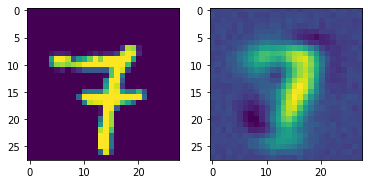

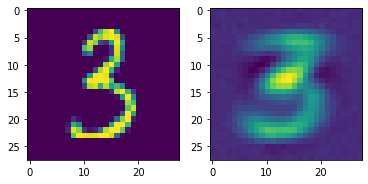

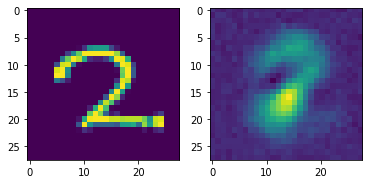

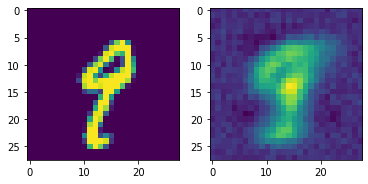

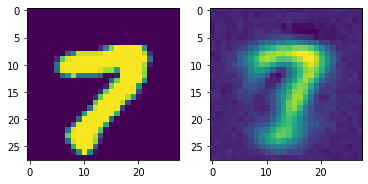

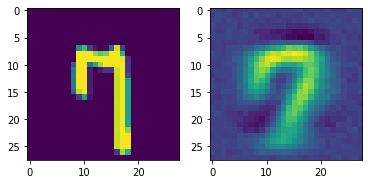

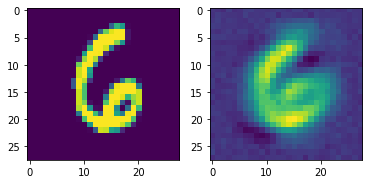

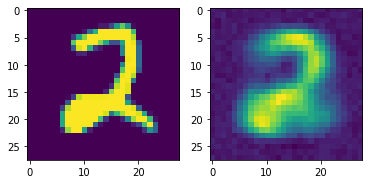

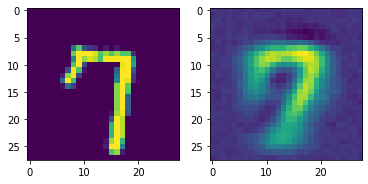

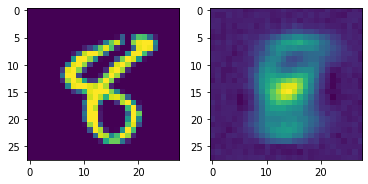

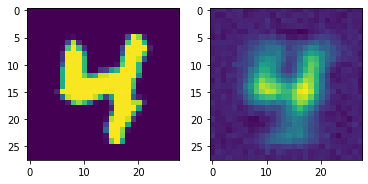

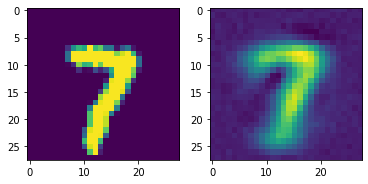

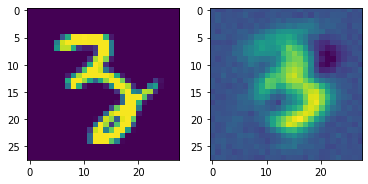

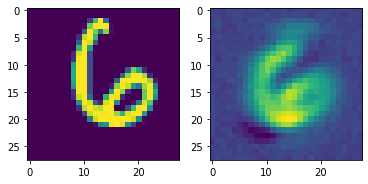

In [11]:
for i in range(75,89):
    show_img(xTest[i])